In [140]:
# Imports
from datetime import datetime, timedelta
import os
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pandas as pd
from scipy.stats import iqr
import shutil
import zipfile
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
from pathlib import Path
import plotly.express as px
import geopandas as gpd
import pyproj
import seaborn as sns

%matplotlib inline


In [143]:
# load data
path_data = os.path.join(os.getcwd(), "data/")
fname_data = os.path.join(path_data, f"data.csv")
df_data = pd.read_csv(fname_data)

# Drop some entries due to wrong age
df_data = df_data.drop(df_data[df_data["Study ID"].isin([95, 179, 186, 296, 419, 851, 1437])].index)

# Converting str to float
df_data = df_data.astype({"Average Age (Years)": 'float64'})

# Replacing NaN (empty info) by 0 values to facilitate calculations
df_data = df_data.fillna(0)

# Adding a column to facilitate averaging by regions
df_data["Number of Studies"] = 1

# Fixing some location mistakes and replacing cities by their regions
df_data["Geographical location"].replace("Montreal", "Montréal", inplace=True)
df_data["Geographical location"].replace("Montreeal", "Montréal", inplace=True)
df_data["Geographical location"].replace("Sherbrooke", "Estrie", inplace=True)
df_data["Geographical location"].replace("Quebec\xa0City", "Capitale-Nationale", inplace=True)
df_data["Geographical location"].replace("Longueuil", "Montérégie", inplace=True)
df_data["Geographical location"].replace("Saguenay Lac St. Jean", "Saguenay - Lac-Saint-Jean", inplace=True)
df_data["Geographical location"].replace("Trois-Rivières", "Mauricie", inplace=True)

# Adding the number of participants
df_data["Number of participants"] = df_data["Male"] + df_data["Female"]
df_data["Ratio Female/Male"] = df_data["Female"] / df_data["Male"]

# Extracting specific data
# study_ids = df_data["Study ID"].values
# location = df_data["Geographical location"].values
# PET_participants = df_data["PET participants"].values
# MRI_participants = df_data["MRI participants"].values
# avg_age = df_data["Average Age (Years)"].values
# male_participants = df_data["Male"].values
# female_participants = df_data["Female"].values
# caucasian_participants = df_data["Caucasian"].values
# AfAm_participants = df_data["African-American"].values
# asian_participants = df_data["Asian"].values
# other_participants = df_data["Other"].values
# NA_participants = df_data["Not specified"].values
# AsA_participants = df_data["Asian American"].values
# midE_participants = df_data["Middle Eastern"].values
# carribean_participants = df_data["Carribean"].values
# jewish_participants = df_data["Jewish"].values
# CauHisp_participants = df_data["Caucasian-Hispanic"].values

# print(np.unique(location))  # Code to check for regions names

""" Code to check for wrong age str
for i, e in enumerate(avg_age):
    try:
        float(e)
    except:
        print(study_ids[i], e)
"""

# Initiating the calculation of a weighted average for each study
df_data['Weighted Average Age'] = df_data['Average Age (Years)'] * df_data['Number of participants']

# Grouping per geographical location and calculating the summation of participants
grouped_df = df_data.groupby('Geographical location')
sum_by_locations = grouped_df.sum()
sum_by_locations['Geographical location'] = sum_by_locations.index

# Calculating the weighted average age per region
sum_by_locations['Weighted Average Age'] = sum_by_locations['Weighted Average Age'] / sum_by_locations['Number of participants']

# Dropping the Study IDs in the groups
sum_by_locations = sum_by_locations.drop('Study ID', axis=1)

/var/folders/_v/nrvjqjyn7mz71bfx98vtg58w0000gn/T/ipykernel_58971/2427550238.py:19: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/_v/nrvjqjyn7mz71bfx98vtg58w0000gn/T/ipykernel_58971/2427550238.py:20: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

In [136]:
# Importing GeoJSON of Quebec regions
with open('data/quebec_regions.geojson') as f:
    geojson = json.load(f)

# Adding regions with zero participants to faciliate display on maps
print(f"Regions added with zero participants : ")
for region in geojson['features']:
    name = region["properties"]["res_nm_reg"]
    if name not in sum_by_locations['Geographical location'].values:
        print(name)
        df_row = {'Geographical location': name, 'PET participants': 0, 'MRI participants': 0, 'Average Age (Years)': 0, 'Male': 0, 'Female': 0, 'Caucasian': 0, 'Black': 0, 'African-American': 0, 'Asian': 0, 'Other': 0, 'Not specified': 0, 'Asian American': 0, 'Middle Eastern': 0, 'Carribean': 0, 'Jewish': 0, 'Caucasian-Hispanic': 0, 'Number of Studies': 0, 'Weighted Average Age': 0}
        sum_by_locations = sum_by_locations._append(df_row, ignore_index=True)

Outaouais
Gaspésie-Îles-de-la-Madeleine
Abitibi-Témiscamingue
Laurentides
Chaudière-Appalaches
Lanaudière
Nord-du-Québec
Côte-Nord
Bas-Saint-Laurent
Laval
Centre-du-Québec


In [138]:
# Display study data on maps using a choropleth graph
fig = px.choropleth(sum_by_locations, geojson=geojson, color="Weighted Average Age",
                    locations="Geographical location", featureidkey="properties.res_nm_reg",
                    projection="mercator", hover_data=["PET participants", "MRI participants", "Weighted Average Age"]
                   )
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [139]:
# Display study data on maps using a choropleth graph with a map in the background
fig = px.choropleth_mapbox(sum_by_locations, geojson=geojson, color="Weighted Average Age",
                           locations="Geographical location", featureidkey="properties.res_nm_reg", 
                           mapbox_style="carto-positron", color_continuous_scale="Viridis",
                           zoom=3, center = {"lat": 50, "lon": -65}, opacity=0.5, 
                           hover_data=["PET participants", "MRI participants", "Weighted Average Age"]
                           )
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

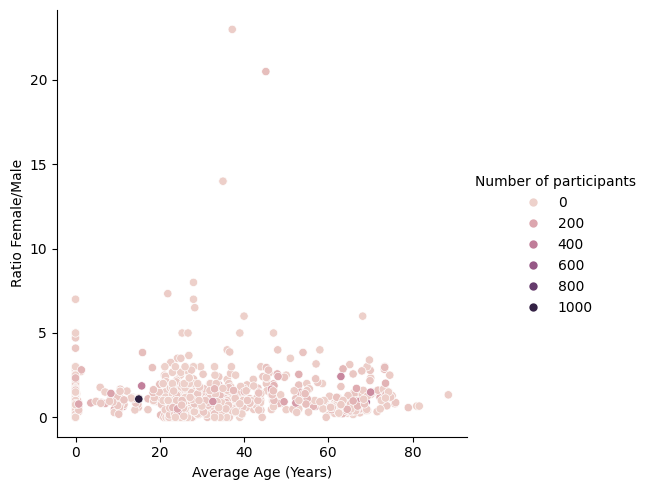

In [145]:
# Show the joint distribution using kernel density estimation
g = sns.relplot(
    data=df_data,
    x="Average Age (Years)", y="Ratio Female/Male",
    hue="Number of participants",
)

(2.0, 24.15)

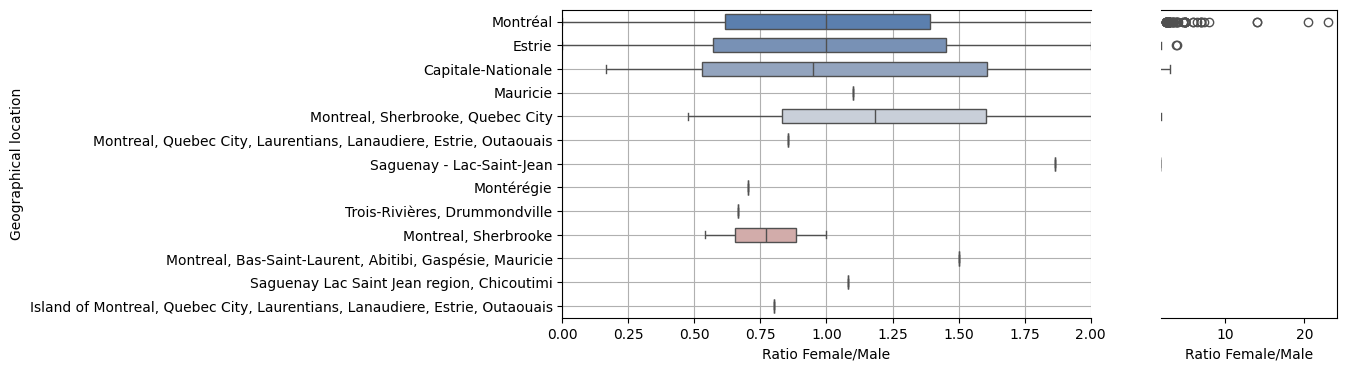

In [158]:
# Show the distribution of the Female/Male ratio depending on the region
# Graphs were separated to display main distribution and outliers.

f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, gridspec_kw={'width_ratios':[3, 1]}, figsize=(10, 4))

sns.boxplot(
    df_data, x="Ratio Female/Male", y="Geographical location", hue="Geographical location", width=.6, palette="vlag", ax=ax1
)
sns.boxplot(
    df_data, x="Ratio Female/Male", y="Geographical location", hue="Geographical location", width=.6, palette="vlag", ax=ax2
)
ax1.grid('on')
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)
ax1.set_xlim(left=0, right=2)
ax2.set_xlim(left=2)